### E-Commerce Sales Data Analysis

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2 as pst

## Connect SQL

In [137]:
import psycopg2

# Define connection parameters
conn = psycopg2.connect(
    host="localhost",
    user="postgres",
    password="mohammad",
    dbname="E-Commerce",
    port="5432"  # PostgreSQL default port is 5432
)

# Create a cursor to interact with the database
cur = conn.cursor()

# Example: Run a query
cur.execute("SELECT version();")
print(cur.fetchone())


('PostgreSQL 17.0 on x86_64-windows, compiled by msvc-19.41.34120, 64-bit',)


### Basic Question

#### Q1. 1. List all unique cities where customers are located.

In [138]:
query = """select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()

c =[city[0] for city in data]
city_list = pd.DataFrame(c,columns=['city_name'])
city_list.head()

,city_name
0,bom jardim de minas
1,alto rio doce
2,alvorada do gurgueia
3,batatais
4,capao da porteira


### 2. Count the number of orders placed in 2017.

In [139]:
query = """select count(order_id) from orders where extract(year from order_purchase_timestamp::date) = 2017"""
cur.execute(query)
data = cur.fetchall()
data[0][0]

print(f"Orders placed in 2017 is {data[0][0]}.")

Orders placed in 2017 is 45101.


### 3. Find the total sales per category.

In [140]:
query = """select products.product_category as Category, round(sum(payments.payment_value)::numeric,2) as sales from delivery as dv
join orders on orders.order_id = dv.order_id
join payments on payments.order_id = orders.order_id
join products on products.product_id = dv.product_id
group by Category order by sales desc;"""
cur.execute(query)
data = cur.fetchall()
total_sales = pd.DataFrame(data, columns=['Category', 'Total_sales'])
total_sales

,Category,Total_sales
0,bed table bath,1712550.00
1,HEALTH BEAUTY,1657370.00
2,computer accessories,1585330.00
3,Furniture Decoration,1430170.00
4,Watches present,1429210.00
...,...,...
69,PC Gamer,2174.43
70,House Comfort 2,1710.54
71,cds music dvds,1199.43
72,Fashion Children's Clothing,785.67


### 4. Calculate the percentage of orders that were paid in installments.

In [141]:
query = """select (sum(case when payment_installments >= 1 then 1 else 0 end))*100/count(*) as installment_per from payments"""
cur.execute(query)
data = cur.fetchall()
data[0][0]
print(f"Percentage of paid in installments is {data[0][0]}% .")

Percentage of paid in installments is 99% .


### 5. Count the number of customers from each state. 

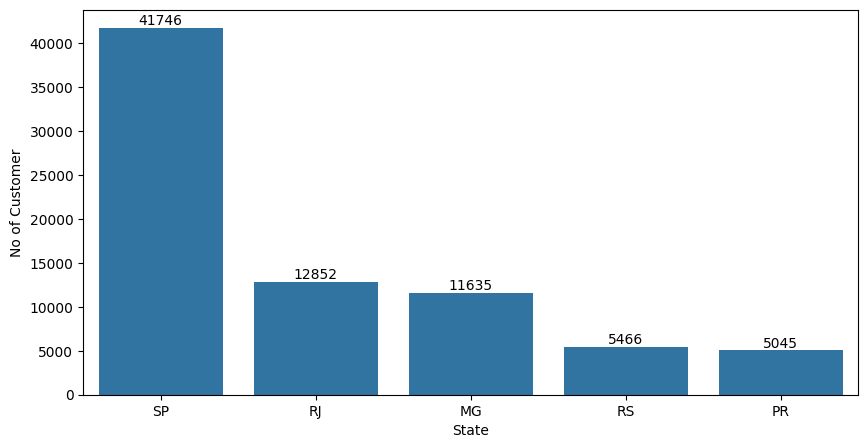

In [142]:
query = """select customer_state, count(customer_id) as count_cus
from customers
group by customer_state
order by count_cus desc"""

cur.execute(query)
data = cur.fetchall()
data

cus_each_state = pd.DataFrame(data, columns=['State','No of Customer'])
top_5_state = cus_each_state.head()
top_5_state

plt.figure(figsize=(10,5))
# plt.bar(top_5_state['State'],top_5_state['No of Customer'])
ax = sns.barplot(data=top_5_state,x='State',y='No of Customer')
for col in ax.containers:
    ax.bar_label(col)
plt.show()

## Intermediate Queries

## 1. Calculate the number of orders per month in 2018.

C:\Users\moham\AppData\Local\Temp\ipykernel_22112\993485831.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df,x='Month',y='No of Orders',palette='viridis')


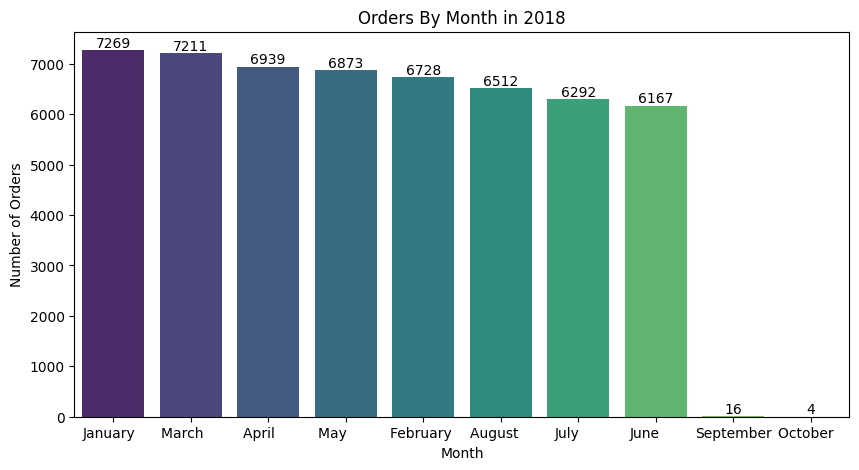

In [143]:
query = """SELECT 
    TO_CHAR(order_purchase_timestamp::timestamp, 'Month') AS month_name,
    COUNT(order_id) AS no_of_order
FROM 
    orders
WHERE 
    EXTRACT(YEAR FROM order_purchase_timestamp::date) = 2018
GROUP BY 
    month_name
ORDER BY 
    no_of_order DESC;"""
    
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Month','No of Orders'])
df
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df,x='Month',y='No of Orders',palette='viridis')
for col in ax.containers:
    ax.bar_label(col)
plt.ylabel('Number of Orders')
plt.xlabel("Month")
plt.title("Orders By Month in 2018")
plt.show()


### 2. Find the average number of products per order, grouped by customer city.

In [144]:
query = """-- Drop the view if it exists
DROP VIEW IF EXISTS product_count;

-- Create the view to calculate the count of products per order
CREATE VIEW product_count AS (
    SELECT 
        orders.order_id, 
        delivery.product_id, 
        COUNT(delivery.product_id) AS p_count 
    FROM 
        orders
    JOIN 
        delivery ON delivery.order_id = orders.order_id
    GROUP BY 
        orders.order_id, delivery.product_id
);

-- Calculate the average number of products per order, grouped by customer city
SELECT 
    customers.customer_city AS cus_city, 
    round(AVG(product_count.p_count),2) AS avg_products_per_order
FROM 
    customers
JOIN 
    orders ON orders.customer_id = customers.customer_id
JOIN 
    product_count ON orders.order_id = product_count.order_id
GROUP BY 
    cus_city
ORDER BY 
    avg_products_per_order DESC;"""
    
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['City', 'avg_products_per_order'])
df.head()

,City,avg_products_per_order
0,datas,6.00
1,candido godoi,6.00
2,matias olimpio,5.00
3,morro de sao paulo,4.00
4,cidelandia,4.00


### 3. Calculate the percentage of total revenue contributed by each product category.

In [145]:
query = """select UPPER(products.product_category) as category,
round((round(sum(payments.payment_value)::numeric,2)/(select sum(payment_value)
from payments))*100) as percentage_of_revenue
from products
join delivery on delivery.product_id = products.product_id
join payments on payments.order_id = delivery.order_id
group by category
order by percentage_of_revenue desc"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Category', 'Percentage_of_total_sales'])
df.head(10)

,Category,Percentage_of_total_sales
0,BED TABLE BATH,11.0
1,HEALTH BEAUTY,10.0
2,COMPUTER ACCESSORIES,10.0
3,WATCHES PRESENT,9.0
4,SPORT LEISURE,9.0
5,FURNITURE DECORATION,9.0
6,HOUSEWARES,7.0
7,COOL STUFF,5.0
8,AUTOMOTIVE,5.0
9,GARDEN TOOLS,5.0


### 4. Identify the correlation between product price and the number of times a product has been purchased.

In [146]:
query  = """select products.product_category,count(order_item.product_id), round(avg(order_item.price)::numeric,2) from products
join order_item on order_item.product_id = products.product_id
group by products.product_category order by count(order_item.product_id) desc"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['category','purchase_count','price'])
d = df.head(20)


# Calculate the correlation between price and purchase_count
correlation = round(df['price'].corr(df['purchase_count']),3)
print("Correlation between price and purchase count:", correlation)


Correlation between price and purchase count: -0.106


### 5. Calculate the total revenue generated by each seller, and rank them by revenue.

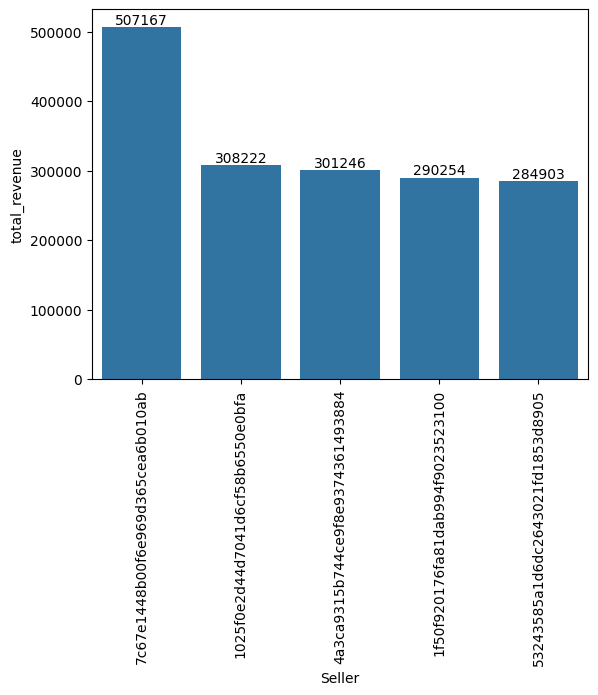

In [147]:
query = """SELECT 
    *,
    DENSE_RANK() OVER (ORDER BY revenue DESC) AS r_n
FROM (
    SELECT 
        sales.seller_id,
        ROUND(SUM(payments.payment_value)::NUMERIC, 2) AS revenue
    FROM 
        sales
    JOIN 
        order_item ON order_item.seller_id = sales.seller_id
    JOIN 
        orders ON orders.order_id = order_item.order_id
    JOIN 
        payments ON payments.order_id = orders.order_id
    GROUP BY 
        sales.seller_id
) AS a
ORDER BY 
    revenue DESC;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Seller','total_revenue','rank'])
d = df.head()
ax = sns.barplot(data= d, x='Seller',y='total_revenue')
for col in ax.containers:
    ax.bar_label(col)
plt.xticks(rotation = 90)
plt.show()

## Advanced Queries

### 1. Calculate the moving average of order values for each customer over their order history.

In [148]:
query = """select customer_id, ord_date, pyment_value,
round(avg(pyment_value) over(partition by customer_id order by ord_date rows between 2 preceding and current row)::numeric,2)as
avg_val
from
(select orders.customer_id as customer_id, orders.order_purchase_timestamp as ord_date,
payments.payment_value as pyment_value
from orders
join payments on payments.order_id = orders.order_id) as a"""

cur.execute(query)
data = cur.fetchall()
df  = pd.DataFrame(data, columns=['customer_id','ord_date','payment_value','moving_avg'])
df.head(10)

,customer_id,ord_date,payment_value,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.80
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.40
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.59
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.23
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.71


### 2. Calculate the cumulative sales per month for each year.

In [149]:
query = """select years, months_no, months, sum(payments) over(order by years,months_no) as cumulative
from
(select extract(year from order_purchase_timestamp::date) as years,
extract(month from order_purchase_timestamp::date) as months_no,
TO_CHAR(order_purchase_timestamp::timestamp,'Month') as months,
round(sum(payments.payment_value)::numeric,2) as payments
from orders
join payments on payments.order_id = orders.order_id
group by years,months_no,months
order by years,months_no) as a"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['years','months_num', 'months_name','cumulative'])
df

,years,months_num,months_name,cumulative
0,2016,9,September,252.24
1,2016,10,October,59342.74
2,2016,12,December,59362.36
3,2017,1,January,197850.36
4,2017,2,February,489758.36
5,2017,3,March,939622.36
6,2017,4,April,1357410.36
7,2017,5,May,1950329.36
8,2017,6,June,2461606.36
9,2017,7,July,3053989.36


### 3. Calculate the year over year growth rate of total sales.

In [151]:
query = """
select years, round(((payment - lag(payment) over(order by years))/(lag(payment) over(order by years)))*100)
from
(select extract(year from order_purchase_timestamp::date) as years, round(sum(payments.payment_value)::numeric,2) as payment
from orders
join payments on payments.order_id = orders.order_id
group by years) as a

"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['years','yoy_%_growth'])
df

,years,yoy_%_growth
0,2016,None
1,2017,12113
2,2018,20


## 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first     purchase.

In [153]:
query = """DROP VIEW IF EXISTS a;

CREATE VIEW a AS (
    SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp::timestamp) AS first_ord
    FROM 
        customers
    JOIN 
        orders ON orders.customer_id = customers.customer_id
    GROUP BY 
        customers.customer_id
);

SELECT 
    a.customer_id,
    COUNT(DISTINCT orders.order_purchase_timestamp) AS order_count
FROM 
    a
JOIN 
    orders ON orders.customer_id = a.customer_id
    AND orders.order_purchase_timestamp::timestamp > first_ord
    AND orders.order_purchase_timestamp::timestamp < first_ord + INTERVAL '18 months'
GROUP BY 
    a.customer_id;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['customer_id','ord_count'])
df

,customer_id,ord_count
